# Assignment 1
## K Nearest Neighbors Model for Binary Classification

## Part A: Model Code

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from pandas.plotting import scatter_matrix
import warnings

warnings.filterwarnings('ignore'

%matplotlib inline

### Task 1 & 2: Euclidean and Manhattan Metrics

In [2]:
def minkowski_dist(v: np.array, w: np.array, p: int) -> float:
    """Calculate the or L_p distance between 2 vectors v and w for an integer p"""
    sum = 0
    for i in range(v.shape[0]):
        difference = abs(v[i]-w[i])
        sum += pow(difference, p)
    return pow(sum, 1/p)

In [3]:
def euclidean_dist(v: np.array, w: np.array) -> float:
    """Calculate the euclidean distance between 2 vectors v and w"""
    return minkowski_dist(v,w,2)

In [4]:
def manhattan_dist(v: np.array, w: np.array) -> float:
    """Calcuate the Manhattan (or L_1) distance between 2 vectors v and w"""
    return minkowski_dist(v,w,1)

### Task 3: Accuracy and Generalization Error

In [6]:
def accuracy(vals: np.array, predictions: np.array) -> float:
    """Calculate the accuracy between the vals vector and the predictions vector"""
    return np.mean(vals == predictions)

In [7]:
def generalization_error(vals: np.array, predictions: np.array)-> float:
    """Calculate the generalization error between the vals and predictions vector"""
    return 1-accuracy(vals, predictions)

### Task 4: Precision, Recall, F1 Scores

In [5]:
class PredictionCountValues:
    """Stores the count values of predicted results and calculates precision and recall"""
    def __init__(self, true_positives, false_positives, true_negatives, false_negatives):
        self.true_positives = true_positives
        self.false_positives = false_positives
        self.true_negatives = true_negatives
        self.false_negatives = false_negatives
    
    def precision(self) -> float:
        """Calculate precision for the given prediction count values"""
        return self.true_positives/(self.true_positives+self.false_positives)

    def recall(self) -> float:
        """Calculate recall for the given prediction count values"""
        return self.true_positives/(self.true_positives+self.false_negatives)
    
    def precision_and_recall(self) -> (float, float):
        """Return precision and recall in a tuple (in that order) for the given prediction count values"""
        return (self.precision(), self.recall())
        
def prediction_count_values(vals: np.array, predicted_probs: np.array, threshold=1) -> PredictionCountValues:
    """
    Determine number of false postive, false negatives, true positives, true negatives for a given threshold and values
    Parameters: 
        vals-target values
        predicted_props-predicted probabilities of target values
        threshold-the threshold at which prediced_probs must be to classify as true. Defaults to 1 to accomodate true predicted vals
    Returns:
        ScoreValueResult containing (# true positives, # false positives, # true negatives, # false negatives)
    """
    true_positives = 0
    false_positives = 0
    true_negatives = 0
    false_negatives = 0
    for idx in range(len(vals)):
        if predicted_probs[idx] >= threshold:
            if vals[idx]:
                true_positives += 1
            else:
                false_positives += 1
        else:
            if vals[idx]:
                false_negatives += 1
            else:
                true_negatives += 1
    return PredictionCountValues(true_positives, false_positives, true_negatives, false_negatives)

In [8]:
def precision(vals: np.array, predictions: np.array)-> float:
    """Calculate the precision=(true positives/total predicted positives) for the vals and predictions vectors"""
    scores = prediction_count_values(vals, predictions)
    return scores.precision()

In [9]:
def recall(vals: np.array, predictions: np.array)-> float:
    """Calculate the recall=(true positives/total positives) for the vals and predictions vectors"""
    scores = prediction_count_values(vals, predictions)
    return scores.recall()

In [10]:
def f1_score(vals: np.array, predictions: np.array)-> float:
    """Calculate the F1 Score = harmonic_mean(precision, recall)"""
    # Technically looping over array twice unnecessarily, could be more efficient, but okay for now
    scores = prediction_count_values(vals, predictions)
    prec, rec = scores.precision_and_recall()
    return (2*prec*rec)/(prec+rec)

### Task 5: Confusion Matrix

In [11]:
def confusion_matrix(vals: np.array, predictions: np.array)-> np.array:
    """Calculate the confusion matrix for the given values and predictions"""
    scores = prediction_count_values(vals, predictions)
    return np.array([[scores.true_negatives, scores.false_positives],[scores.false_negatives, scores.true_positives]])

In [12]:
def generate_thresholds(min_val: int, max_val: int, threshold_step_size: float)-> np.array:
    """Generate threshold values of a given step size from min_val to max_val always including both min and max vals"""
    return np.append(np.arange(min_val,max_val,threshold_step_size), [max_val])

### Task 6: Generate ROC Curve

In [13]:
def calculate_tpr_fpr(vals: np.array, pred_score_probs: np.array, threshold: float)->(float, float):
    """Calculate TPR and FPR and return as tuple (tpr, fpr)"""
    scores = prediction_count_values(vals, pred_score_probs, threshold)
    tpr = scores.true_positives/(scores.true_positives+scores.false_negatives)
    fpr = scores.false_positives/(scores.false_positives+scores.true_negatives)
    return (tpr, fpr)

In [14]:
def roc_curve(vals: np.array, pred_scores: np.array, threshold_step_size: float = 0.0005) -> (np.array, np.array, np.array):
    # NOTE: scikitlearn I think does some fancy things to calculate appropriate thresholds...we'll just use a set step size
    max_threshold = 2.0
    thresholds = np.append(generate_thresholds(0,1,threshold_step_size), [max_threshold])
    thresholds = np.flip(thresholds)
    tprs = np.empty(len(thresholds))
    fprs = np.empty(len(thresholds))
    for idx, threshold in enumerate(thresholds):
        tpr, fpr = calculate_tpr_fpr(vals, pred_scores, threshold)
        tprs[idx] = tpr
        fprs[idx] = fpr
    return (tprs, fprs, thresholds)

In [15]:
def plot_roc_curve(true_positive_rate: np.array, false_positive_rate: np.array, title='ROC Curve', label=None)-> None:
    plt.style.use('ggplot')
    fig = plt.figure(figsize=(10,6))
    plt.plot(false_positive_rate, true_positive_rate, color='darkorange', linewidth=7, label=label)
    plt.plot([0,1], [0,1], color='black', lw=2, linestyle='--')
    plt.axis([0,1,0,1])
    plt.title(title)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.show()

### Task 7: Compute Area Under Curve for ROC Curve

In [16]:
def roc_auc_score(y_vals: np.array, y_predicted_probs: np.array) -> float:
    """Calculate AUC of the ROC for the given y_vals and y_predicted_probs using the trapezoidal rule"""
    auc = 0
    tprs, fprs, _ = roc_curve(y_vals, y_predicted_probs)
    # Uses the trapezoidal rule for calculating AUC
    for idx in range(len(tprs)-1):
        average_tpr = (tprs[idx]+tprs[idx+1])/2
        delta_fpr = fprs[idx+1]-fprs[idx]
        trap_area = average_tpr*delta_fpr
        auc += trap_area
    return auc

### Task 8: Generate Precision-Recall Curve

In [17]:
def precision_recall_curve(vals: np.array, predicted_scores: np.array, threshold_step_size=0.0005) -> (np.array, np.array, np.array):
    """Calculate precision recall curve and return precisions, recalls, thresholds"""
    thresholds = generate_thresholds(0,1,threshold_step_size)
    precisions = np.empty(len(thresholds))
    recalls = np.empty(len(thresholds))
    thresholds = np.flip(thresholds) # Reverse thresholds array
    for idx, threshold in enumerate(thresholds):
        scores = prediction_count_values(vals, predicted_scores, threshold)
        precisionScore, recallScore = scores.precision_and_recall()
        precisions[idx] = precisionScore
        recalls[idx] = recallScore
    return (precisions, recalls, thresholds)

In [18]:
def plot_precision_recall_curve(precisions: np.array, recalls: np.array, thresholds: np.array, title='Precision-Recall Curve') -> None:
    plt.style.use('ggplot')
    fig = plt.figure(figsize=(10,6))
    plt.plot(thresholds, precisions, 'b--', linewidth=8, label='Precision')
    plt.plot(thresholds, recalls, 'g-', linewidth=3, label='Recall')
    plt.xlabel('Threshold')
    plt.legend(loc='lower left')
    plt.title(title)
    plt.ylim([0,1.1])
    plt.show()

### Task 9: KNN_Classifier Model Class

In [19]:
class KNN_Classifier:
    """KNN classifier"""
    def __init__(self):
        pass
    
    def fit(self, X: np.array, Y: np.array, n_neighbors: int, weights = 'uniform', **kwargs) -> None:
        """
        Initialize the KNN classifier values. Note p is the power on the Minkowski metric
        NOTE: If you want to use a specific metric put it in kwargs with the metric parameter
        Currently implemented metrics are manhattan and euclidean
        """
        self.X = X
        self.Y = Y
        self.n_neighbors = n_neighbors
        self.weights = weights
        self.kwargs = kwargs
        self.metric = manhattan_dist if ('metric' in kwargs and kwargs['metric'] == 'manhattan') else euclidean_dist
    
    def predict(self, X: np.array)-> np.array:
        """Predict the classification of each input in given ndarray"""
        preds = np.empty(X.shape[0])
        for idx, x in enumerate(X):
            neighborhood = self.__find_neighbors(x)
            neighbors = [(distance, self.Y[neighbor]) for distance, neighbor in neighborhood]
            if self.weights is 'distance':
                class1_score = 0
                class2_score = 0
                for dist, y in neighbors:
                    if y:
                        class1_score += (1/dist)
                    else:
                        class2_score += (1/dist)
                preds[idx] = 1 if class1_score > class2_score else 0
            else:
                nearest_nei_total_true = sum(val for _, val in neighbors)
                preds[idx] = 1 if nearest_nei_total_true > (self.n_neighbors/2) else 0
        return preds
            
    def __find_neighbors(self, sample: np.array) -> list:
        """Find list of nearest neighbors"""
        distances = []
        # Note: could try to optimize and keep track of nearest neighbors as you go but ends up with lots of operations on neighbors list
        for idx, data in enumerate(self.X):
            distance = self.metric(sample, data)
            distances.append((distance, idx))
        return sorted(distances)[:self.n_neighbors]

## Part B: Data Processing

### Task 10: Read in the wine quality data

In [ ]:
# Considering shipping the dataset with the code and creating a function that reads it from its location
wine_df = pd.read_csv('/Projects/Machine-Learning/datasets/DataScienceRepository/wine-quality/winequality-white.csv', delimiter=';')

### Task 11: Convert target column to two-category column

In [ ]:
wine_df['quality'] = (wine_df['quality'] > 5).astype(np.int)

### Task 12: Summarize variables

In [ ]:
wine_df.describe()

### Task 13: Shuffle data

In [ ]:
wine_shuffled_df = wine_df.sample(frac=1)

### Task 15: Drop redudant features

In [ ]:
# Dropping 'density' and 'total sulfur dioxide' in recitation 3 gave the best overall statistics
wine_shuffled_df.drop(columns=['density', 'total sulfur dioxide'])

### Task 14: Generate pair plots

In [ ]:
#Just used the code from the recitation. I'm not sure if this is a problem and if using scipy is allowed. If it is a problem, I'm going to redo this part 
#If it's not a problem, I will have to write a proper citation right here
# Calculate correlation coefficient
def corrfunc(x, y, **kws):
    r, _ = stats.pearsonr(x, y)
    ax = plt.gca()
    ax.annotate("r = {:.2f}".format(r),
                xy=(.1, .6), xycoords=ax.transAxes,
               size = 24)
    
cmap = sns.cubehelix_palette(light=1, dark = 0.1,
                             hue = 0.5, as_cmap=True)

sns.set_context(font_scale=2)

# Pair grid set up
g = sns.PairGrid(wine_shuffled_df)

# Scatter plot on the upper triangle
g.map_upper(plt.scatter, s=10, color = 'red')

# Distribution on the diagonal
g.map_diag(sns.distplot, kde=False, color = 'red')

# Density Plot and Correlation coefficients on the lower triangle
g.map_lower(sns.kdeplot, cmap = cmap)
g.map_lower(corrfunc)

### Task 15: Drop redudant features

In [ ]:
# Dropping 'density' and 'total sulfur dioxide' in recitation 3 gave the best overall statistics
wine_shuffled_df.drop(columns=['density', 'total sulfur dioxide'])

### Task 16: Create partition function

In [ ]:
def partition(features, target, part_size):
    length = features.shape[0]
    part = round(part_size * length)
    part_arr = np.random.choice(range(length), part, False)

    index_arr = np.zeros(length, dtype=bool)
    index_arr[part_arr] = True

    X_test = features[index_arr]
    X_train = features[~index_arr]
    y_test = target[index_arr]
    y_train = target[~index_arr]

    return X_train, X_test, y_train,y_test

In [ ]:
def standardize_features(features):
    X_mean = np.mean(features, axis=1)
    X_std = np.std(features, axis=1)

    X_standardized = (features - X_mean) / X_std

    return X_standardized

### Task 17: Run KNN_Classifier model on train dataset

# Test Things Below (DELETE BEFORE SUBMISSION)

### Just simple non-rigorous sanity checks

In [20]:
# VERY QUICK NOT RIGOROUS TEST CELL
y_vals = np.array([1,0,1,1,0,0,0,1,1,0,0,1,1,1])
y_preds = np.array([0,1,1,1,0,0,0,1,0,1,0,0,1,0])
print(len(y_vals))
print(accuracy(y_vals,y_preds))
print(generalization_error(y_vals, y_preds))
print(precision(y_vals, y_preds))
print(recall(y_vals, y_preds))
print(f1_score(y_vals, y_preds))
print(confusion_matrix(y_vals,y_preds))


14
0.5714285714285714
0.4285714285714286
0.6666666666666666
0.5
0.5714285714285715
[[4 2]
 [4 4]]


In [21]:
# Loading data from reci3 to get test data
from pathlib import Path 
test_data = Path('/Users/scott.martin/Documents/unl_box/Box Sync/courses/csce878_machine_learning/recitations/recitation3')
y_scores = []
with open(test_data/'y_scores.csv') as file:
    for line in file:
        y_scores.append(float(line.strip()))
    
y_vals = []
with open(test_data/'y_values.csv') as file:
    for line in file:
        y_vals.append(float(line.strip()))

y_scores = np.array(y_scores)
y_vals = np.array(y_vals)

In [22]:
tpr, fpr, thresholds = roc_curve(y_vals, y_scores) # This is SOOOOOO SLOW!!! Speed it up...I'm being dumb

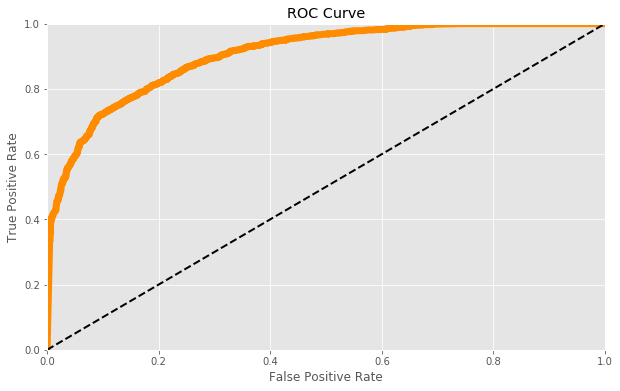

In [23]:
plot_roc_curve(tpr, fpr)

In [24]:
roc_auc_score(y_vals,y_scores) # Still hideously slow...but okay

0.9045316774078174

In [25]:
precision_tests, recall_tests, new_thresh = precision_recall_curve(y_vals, y_scores)

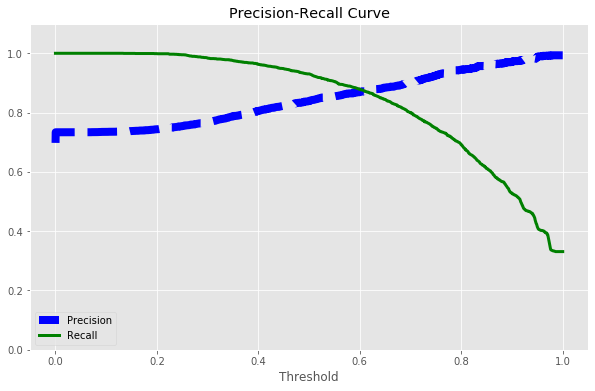

In [26]:
plot_precision_recall_curve(precision_tests, recall_tests, new_thresh)

In [27]:
df = pd.read_csv(test_data/'winequality-white.csv', delimiter=';')
target = (df['quality']>5).astype(np.int)
df = df.drop(columns=['quality'])

In [28]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import scale
x_train, x_test, y_train, y_test = train_test_split(df, target)
x_train = scale(x_train)
x_test = scale(x_test)

In [29]:
knn = KNN_Classifier()
knn.fit(x_train, y_train.values, 9)

In [30]:
rsm_x_test = x_test
rsm_y_test = y_test.values

In [31]:
ys = knn.predict(rsm_x_test)

In [32]:
print(accuracy(rsm_y_test, ys))

0.7795918367346939
